# Method 2
## Approach for PCB Defect Detection

- **Problem Definition:** We aim to detect defects in PCB (Printed Circuit Board) chips.

- **Target Variable:** 
  - Defected PCBs will be labeled as **1**.
  - Non-defected PCBs will be labeled as **0**.

- **Objective:** Train a machine learning model to classify PCBs into defected and non-defected categories.

- **Model Development:**
  1. **Manual CNN**: Initially, convolutional layers were manually applied to extract relevant features from the images. This was done using a simple Convolutional Neural Network (CNN) to detect PCB defects.
  
  2. **Pre-trained Model (ResNet50)**: To improve the accuracy, a pre-trained model, **ResNet50**, was utilized. This model is known for its deep architecture and ability to learn complex features effectively. It was pre-trained on a large dataset (ImageNet) and adapted for our PCB defect detection task.
  
  3. **Fine-Tuning**: The ResNet50 model was fine-tuned by unfreezing some of its layers to allow learning specific to the PCB defect detection task. This helps in better adapting the model to our dataset, improving performance over just using the pre-trained features.

This approach leverages both custom-built convolutional layers and a pre-trained network to maximize the model's ability to accurately classify defective and non-defective PCBs.


Displaying 9 random defect-free PCB images...


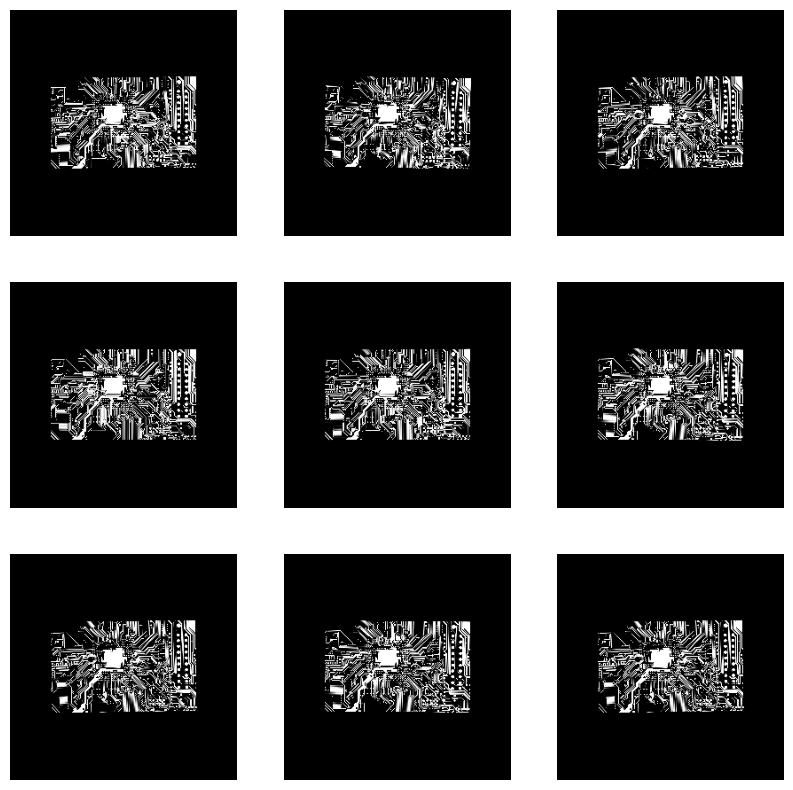

In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to load and resize images from a given folder
def load_images_from_folder(folder, size=(256, 256)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, size)  # Resize image
            if len(img.shape) == 2:  # If grayscale, convert to RGB
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            images.append(img)
    return np.array(images)

# Define the paths to your image folders
golden_folder = '/kaggle/input/without-yolo-data/segmentation_data/non_defects'  
defective_folders = ['/kaggle/input/without-yolo-data/segmentation_data/defects']

# Load images from each folder
golden_images = load_images_from_folder(golden_folder)
defective_images = []

for folder in defective_folders:
    defective_images.extend(load_images_from_folder(folder))

# Convert lists to numpy arrays
golden_images = np.array(golden_images)
defective_images = np.array(defective_images)

# Visualize a few sample images from the training set
def plot_images(images, n=9, figsize=(10, 10)):
    """Function to display n images in a grid."""
    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(3, 3, i+1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        plt.axis('off')  # Hide axes for cleaner view
    plt.show()

# Visualize 9 random images from the golden_images (defect-free) set
print("Displaying 9 random defect-free PCB images...")
plot_images(golden_images)

### Making labels and splitting the dataset

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split


# Label the images
golden_labels = np.zeros(len(golden_images))  # Label 0 for defect-free images
defective_labels = np.ones(len(defective_images))  # Label 1 for defective images

# Combine the images and their labels
images = np.concatenate((golden_images, defective_images), axis=0)
labels = np.concatenate((golden_labels, defective_labels), axis=0)

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Check the shapes of the resulting splits
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")
X_train = X_train / 255.0
X_test = X_test / 255.0

Training data shape: (518, 256, 256, 3), Training labels shape: (518,)
Test data shape: (130, 256, 256, 3), Test labels shape: (130,)


### Data Augmentation

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation for training data
datagen = ImageDataGenerator(
    rotation_range=2,  
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=False, 
    vertical_flip=False,  
    brightness_range=[0.8, 1.2],  
    fill_mode='nearest'  
)
# Apply data augmentation to the training data
train_generator = datagen.flow(X_train, y_train, batch_size=8)

# No augmentation for test data
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(X_test, y_test, batch_size=8)

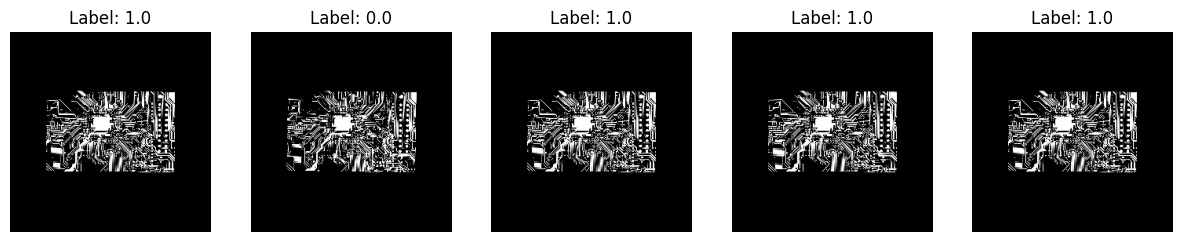

In [24]:
import matplotlib.pyplot as plt

# Function to display images and their labels
def show_images_with_labels(X, y, num_images=5):
    # Randomly select a few images from the dataset
    indices = np.random.choice(len(X), num_images, replace=False)
    
    # Create a figure to plot the images
    plt.figure(figsize=(15, 10))
    
    for i, index in enumerate(indices):
        # Get the image and its label
        img = X[index]
        label = y[index]
        
        # Plot the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)  # Show the image
        plt.title(f"Label: {label}")  # Show the label
        plt.axis('off')  # Hide axes
    
    plt.show()

# Display 5 random images from the training set along with their labels
show_images_with_labels(X_train, y_train, num_images=5)

### Model Making

In [25]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,777,281 (33.48 MB)

 Trainable params: 8,777,281 (33.48 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

# Defining the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,         
    verbose=1,           
    restore_best_weights=True 
)

# Training the model with augmented data and early stopping
history = model.fit(
    train_generator,       
    epochs=20,            
    validation_data=test_generator, 
    verbose=1,             
    callbacks=[early_stopping] 
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.4967 - loss: 0.7060 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.5032 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.5380 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.5214 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.5131 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.5031 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.5057 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


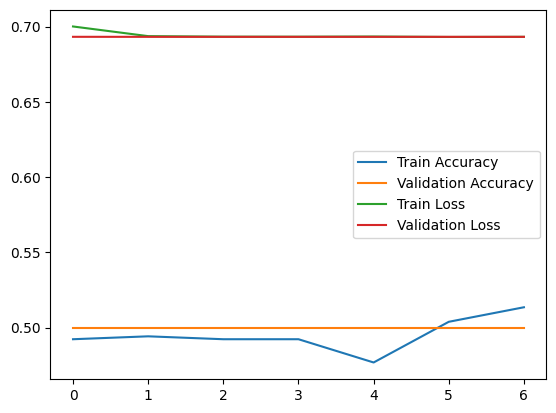

In [28]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy/loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


## Observations

It is clearly seen from the results that the model is overfitting and not performing well due to the following reasons:

1. **Image Resizing to 256x256**: 
   - The PCB needs to be analyzed more precisely, and image resizing will not help in capturing the finer details.
   
2. **Computational Expense of Larger Images**:
   - If we don't resize the images, it becomes computationally expensive. Working with 1500x1500 images would be expensive as well. The images in the dataset are 3000x3000, which requires significant processing power that I currently do not have access to.

3. **Small Dataset**: 
   - The dataset is too small, and the validation data contains the same images as the training set, leading to overfitting.

## Solutions

1. **Increase Dataset Size**:
   - A larger dataset with different variations of PCB images can help in avoiding overfitting and improving accuracy.

2. **Leverage High-Performance Computing**:
   - With high computational resources and powerful GPUs, we can train the model on the original image size, which is expected to improve accuracy.


# Using pre-trained model

In [29]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model to prevent overfitting
base_model.trainable = False

# Add custom layers on top of the base model
inputs = base_model.input
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model_new = Model(inputs=inputs, outputs=outputs)

# Compile the model
model_new.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_new.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [30]:
history_fine = model_new.fit(
    train_generator,
    epochs=20,  
    validation_data=test_generator )

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 228ms/step - accuracy: 0.4819 - loss: 0.8068 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.5269 - loss: 0.7236 - val_accuracy: 0.5000 - val_loss: 0.7002
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.5793 - loss: 0.6909 - val_accuracy: 0.5000 - val_loss: 0.6922
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.5232 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.4925 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.5166 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.5128 - loss: 0.6921 - val_accuracy: 0.6385 - val_loss: 0.6920
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.5345 - loss: 0.6929 - val_accuracy: 0

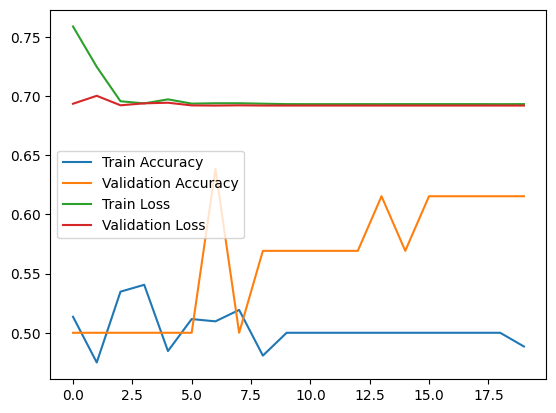

In [31]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy/loss
plt.plot(history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


### Fine-Tuning ( Freezing all layers except the top 20 )

In [32]:
for layer in base_model.layers[:-20]:
    layer.trainable = False
model_new.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,374,917 (92.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 524,804 (2.00 MB)

In [34]:
history_fine_tuned = model_new.fit(
    train_generator,
    epochs=20, 
    validation_data=test_generator )

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.5412 - loss: 0.6929 - val_accuracy: 0.4692 - val_loss: 0.6920
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.5158 - loss: 0.6930 - val_accuracy: 0.5692 - val_loss: 0.6920
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.4874 - loss: 0.6933 - val_accuracy: 0.5692 - val_loss: 0.6920
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.4829 - loss: 0.6933 - val_accuracy: 0.6154 - val_loss: 0.6920
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.4486 - loss: 0.6934 - val_accuracy: 0.6154 - val_loss: 0.6920
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.4938 - loss: 0.6932 - val_accuracy: 0.6154 - val_loss: 0.6920
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.4940 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6971
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.5136 - loss: 0.6954 - val_accuracy: 0.

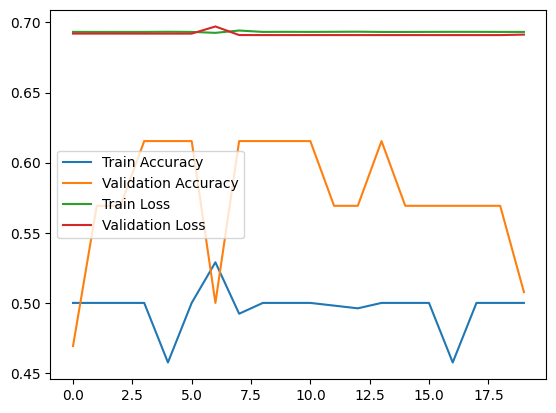

In [35]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy/loss
plt.plot(history_fine_tuned.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine_tuned.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine_tuned.history['loss'], label='Train Loss')
plt.plot(history_fine_tuned.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


### Issue After Fine-Tuning Pre-Trained Model

Even after fine-tuning a pre-trained model, the results have not been satisfactory due to the following reasons:

1. **Complexity of PCB Image Detection**:
   - PCB image detection requires high precision, making it a complex task that is challenging for models to perform accurately.

2. **Increased Computational Expense**:
   - The current image resolution is small, making it difficult for the model to identify defects accurately. Increasing the resolution to something like 3000x3000 would provide more detail, but it would also make the computation much more expensive.

3. **Small Dataset**:
   - The dataset is too small, leading to overfitting and preventing the model from generalizing well to new, unseen data.


# Thank you